In [3]:
import numpy as np
import torch
import torch.nn.functional
from e3nn import o3
from matplotlib import pyplot as plt
import ase.io
%matplotlib inline
from ase.visualize import view
from scipy.spatial.transform import Rotation

from hforge.mace import data, modules, tools
from hforge.mace.tools import torch_geometric
torch.set_default_dtype(torch.float64)
import warnings
warnings.filterwarnings("ignore")

In [4]:
# setup some default prameters
z_table = tools.AtomicNumberTable([1, 6, 8])
atomic_energies = np.array([-1.0, -3.0, -5.0], dtype=float)
cutoff = 3

default_model_config = dict(
        num_elements=3,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("8x0e + 8x1o"),  # 8: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("16x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
    )
default_model = modules.MACE(**default_model_config)

 mcheck node_feats_irreps= 8x0e
mcheck node_attr_irreps= 3x0e
num_elements--- 3
mace -- ssh_irreps 1x0e+1x1o+1x2e
interaction class seting: {'node_attrs_irreps': 3x0e, 'node_feats_irreps': 8x0e, 'edge_attrs_irreps': 1x0e+1x1o+1x2e, 'edge_feats_irreps': 8x0e, 'target_irreps': 8x0e+8x1o+8x2e, 'hidden_irreps': 8x0e+8x1o, 'avg_num_neighbors': 8, 'radial_MLP': [64, 64, 64], 'cueq_config': None}


In [5]:
z_table

In [6]:
z_table.zs

[1, 6, 8]

In [13]:
# a function for Ylms where we evaluate for l=0,1,2.
spherical_harmonics = o3.SphericalHarmonics([0,1,2], True)

# evaulate spherical harmonics on a vector
vector = torch.tensor([1.0, 0.2, 0.75])
print(spherical_harmonics(vector))

tensor([ 0.2821,  0.3860,  0.0772,  0.2895,  0.5113,  0.1364, -0.2918,  0.1023,
        -0.1491])


shape of Y_lms array is  torch.Size([360, 9])


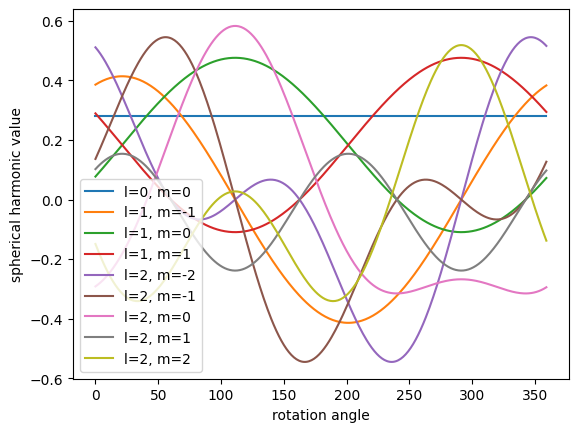

In [8]:
# make a list of rotated versions of the vector
rotated_vectors = []
vector = np.array([1.0, 0.2, 0.75])
N=360
for i in range(N):
    rotation_matrix = Rotation.from_rotvec(i * 2*np.pi * np.array([0, 0.7071, 0.7071])/360).as_matrix() # rotate around the vector [0, 0.7071, 0.7071]
    rotated_vectors.append(rotation_matrix @ vector)

# convert to torch tensor
rotated_vectors = torch.tensor(rotated_vectors, dtype=torch.float32)

# compute the spherical harmonics for each vector
spherical_harmonic_values = spherical_harmonics(rotated_vectors)
print('shape of Y_lms array is ', spherical_harmonic_values.shape)

# plots
labels = [[f'l={l}, m={m}' for m in range(-l,l+1)] for l in range(3)]
labels = [x for xs in labels for x in xs] # flatten
plt.plot(spherical_harmonic_values.numpy(), label=labels)
plt.legend()
plt.xlabel('rotation angle')
plt.ylabel('spherical harmonic value')
plt.show()

The key points to note are that the $l=0$ component is constant - it does not change when the vector is rotated.  The other components do change, and as $l$ increases the frequency of the features increases.

## Getting Invariant Quantities with `e3nn`

Enevtually we want to make a model where the output is invariant to rotations. To do this, we could just take the $l=0$ piece of the spherical harmonics, but doing this doesn't give us much information.

For example: Lets take a pair of vectors, get the spherical harmonics for both.

In [12]:
np.random.seed(0)
vector1 = np.random.randn(3)
vector1 = vector1 / np.linalg.norm(vector1)
vector2 = np.random.randn(3)
vector2 = vector2 / np.linalg.norm(vector2)

spherical_harmonics_1 = spherical_harmonics(torch.tensor(vector1))
spherical_harmonics_2 = spherical_harmonics(torch.tensor(vector2))

print('l=0 component for vector 1:', spherical_harmonics_1[0])
print('l=0 component for vector 2:', spherical_harmonics_2[0])

l=0 component for vector 1: tensor(0.2821)
l=0 component for vector 2: tensor(0.2821)


This isn't very useful, because the $l=0$ piece doesn't contain any angular information for either vector, so we have no way to know, for instance, the angle between them.

You can test this by changing one or both of the vectors (via the numpy seed). The $l=0$ piece won't change.

### How do we get Invariants which describe angular information?

To get a more descriptive invariant quantity, we need to do some operations on the spherical harmoincs. We care about how spherical harmonics change when you rotate the input, because its easy to keep track of how rotation affects things. This means that its easy to get back to an invariant quantity when we need to. In MACE, and many other MLIPs, this maths is done by a package called `e3nn`.

`e3nn` provides functions which perform operations on spherical tensors (things with elements like $[Y_{0}^0, Y_{1}^{-1}, Y_{1}^0, ...]$), while keeping track of the rotations. One example operation is a tensor product, which takes two arrays, $A_{lm}$ and $B_{lm}$, and multiplies them to give $C_{lm}$:

$$[A_{lm}] \ \otimes \ [B_{lm}] \ = \ [C_{lm}]$$

The key is that $C$ is still indexed by $l$ and $m$, so if we look at the $l=0$ piece, it will still be invariant! This means we can do a load of operations to combine spherical harmonics, and then create invariant descrpitors which know about things like angles ebtween vectors.

We can demonstrate this by the two vectors above, doing the tensor product of them, and keeping all the outputs which are invariant to rotations.

FullyConnectedTensorProduct(1x0e+1x1o+1x2e x 1x0e+1x1o+1x2e -> 3x0e | 9 paths | 9 weights)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

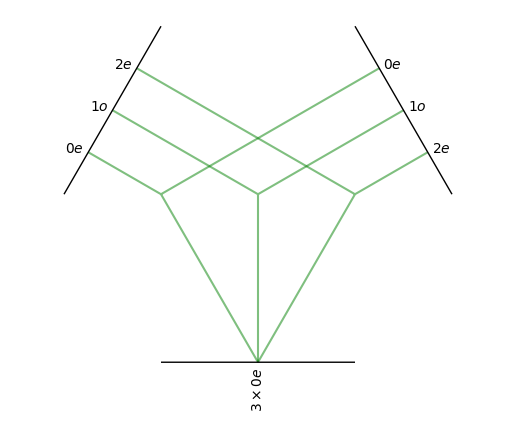

In [10]:
# set up a tensor product.
# This does the product of two l=0,1,2 arrays, and maps the result to three l=0 values.
tensor_product = o3.FullyConnectedTensorProduct(
    irreps_in1=o3.Irreps("1x0e + 1x1o + 1x2e"),
    irreps_in2=o3.Irreps("1x0e + 1x1o + 1x2e"),
    irreps_out=o3.Irreps("3x0e"),
    internal_weights=False
)
print(tensor_product)
tensor_product.visualize()

In [25]:
tensor_product

FullyConnectedTensorProduct(1x0e+1x1o+1x2e x 1x0e+1x1o+1x2e -> 3x0e | 9 paths | 9 weights)

The diagram shows schematically how the tensor product is combining the elements of the inputs to make the output.

In [26]:
# product the arrays
product = tensor_product(
    spherical_harmonics_1.unsqueeze(0),
    spherical_harmonics_2.unsqueeze(0),
    weight=torch.arange(1,10,1) # the product has weights which can be trained - for now I have fixed them
)
print('invariant outputs:', product)

invariant outputs: tensor([[0.2524, 0.3480, 0.4436]])


Now we have three outputs, and they have the property that they are invariant to rotations of the *entire* structure (i.e. rotating oth vectors) but then still change when the angle between the vectors changes.

We can demonstrate this:

In [15]:
angle = 77.7 # degrees
rotation_matrix = Rotation.from_rotvec(angle * 2*np.pi * np.array([0, 0.7071, 0.7071])/360).as_matrix()

rotated_vec1 = rotation_matrix @ vector1
rotated_vec2 = rotation_matrix @ vector2

# get the spherical harmpnics
spherical_harmonics_1 = spherical_harmonics(torch.from_numpy(rotated_vec1))
spherical_harmonics_2 = spherical_harmonics(torch.from_numpy(rotated_vec2))

product = tensor_product(
    spherical_harmonics_1.unsqueeze(0),
    spherical_harmonics_2.unsqueeze(0),
    weight=torch.arange(1,10,1) # the product has weights which can be trained - for now I have fixed them
)
print('invariant outputs:', product)

invariant outputs: tensor([[0.2524, 0.3480, 0.4436]])


You can see that the values are the same as before the rotation, but if you go back and change the seed used for creating the two vectors, they will be different. This meas that we have have made invariant quantities which can tell two pairs of unit vectors apart.

These kind of operations are what MACE is built on.

# MACE Feature Construction

We can now go through some key parts of the feature construction and look at the internal variables. The schematic at the top of the document has a full overview, and the key bits will be repeated.

## 0. Data Prep

The first step in MACE is to take the atomic structure and represent it as a list of atoms and 'edges'. An edge is simply a connection between two atoms. The cutoff radius of the MACE layer determines which atoms are connected by an edge.

Below we load a list of molecule, and show how the atoms and edges are stored.

In [30]:
single_molecule = ase.io.read('data2/solvent_rotated.xyz', index='0')

Rcut = 3.0 # cutoff radius
z_table = tools.AtomicNumberTable([1, 6, 8])

config = data.Configuration(
    atomic_numbers=single_molecule.numbers,
    positions=single_molecule.positions
)

# we handle configurations using the AtomicData class
batch = data.AtomicData.from_config(config, z_table=z_table, cutoff=Rcut)
print("positions:", batch.positions)
print("node_attrs:", batch.node_attrs)
print("edge_index:", batch.edge_index)

positions: tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.7586,  0.0000,  0.5043],
        [-0.7586,  0.0000,  0.5043],
        [ 1.2000,  0.0000, -1.0000],
        [ 1.8000,  0.0000, -1.8000]])
node_attrs: tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])
edge_index: tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 0, 1, 2, 4, 0, 1, 3]])


The `node_attrs` describe the species. `[1,0,0]` means the first kind of element, `[0,1,0]` means the second kind, and so on.

In this case we told MACE to work with Hydrogen, Carbon and Oxygen with the line `z_table = ...`.

The 'edges' are stored by a list of 'senders' and 'receievers', which represent the start and end point of each edge.

We can now compute the lengths and directions of each edge:

In [32]:
vectors, lengths = modules.utils.get_edge_vectors_and_lengths(
    positions=batch["positions"],
    edge_index=batch["edge_index"],
    shifts=batch["shifts"],
)
print(f'there are {batch.positions.shape[0]} nodes and {len(lengths)} edges')
print(f'lengths is shape {lengths.shape}')
print(f'vectors is shape {vectors.shape}')

there are 5 nodes and 18 edges
lengths is shape torch.Size([18, 1])
vectors is shape torch.Size([18, 3])



## 1. Embeddings

We now take this information and make the initial inputs to the MACE model. This is called the embedding.

#### Key concept: MACE 'channels'

The equation for the initial node features looks like this:
$$h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zz_{i}}$$
Take the exmaple where all atoms are either hydrogen or carbon. If atom $i$ is hydrogen, the its initial node features are just $W_{k0}$. If atom $n$ is carbon it will get initial features $W_{k1}$. This means that each atom is given a vector of length $K$, based on its chemical species.

```In mace, the range of k is referred to as the number of 'channels'. This is the fundamental 'size' of the descriptor```
the figure at the top of the notebook sort of shows this.

This operation of giving each atom a length-K vector depending on its species is called the node 'embedding'.

We also 'embed' the lengths and directions of the edges. The lengths of the edges are mapped through a set of 8 bessel functions, and for the dircetion of the edge we just calculate the spherical harmoincs.

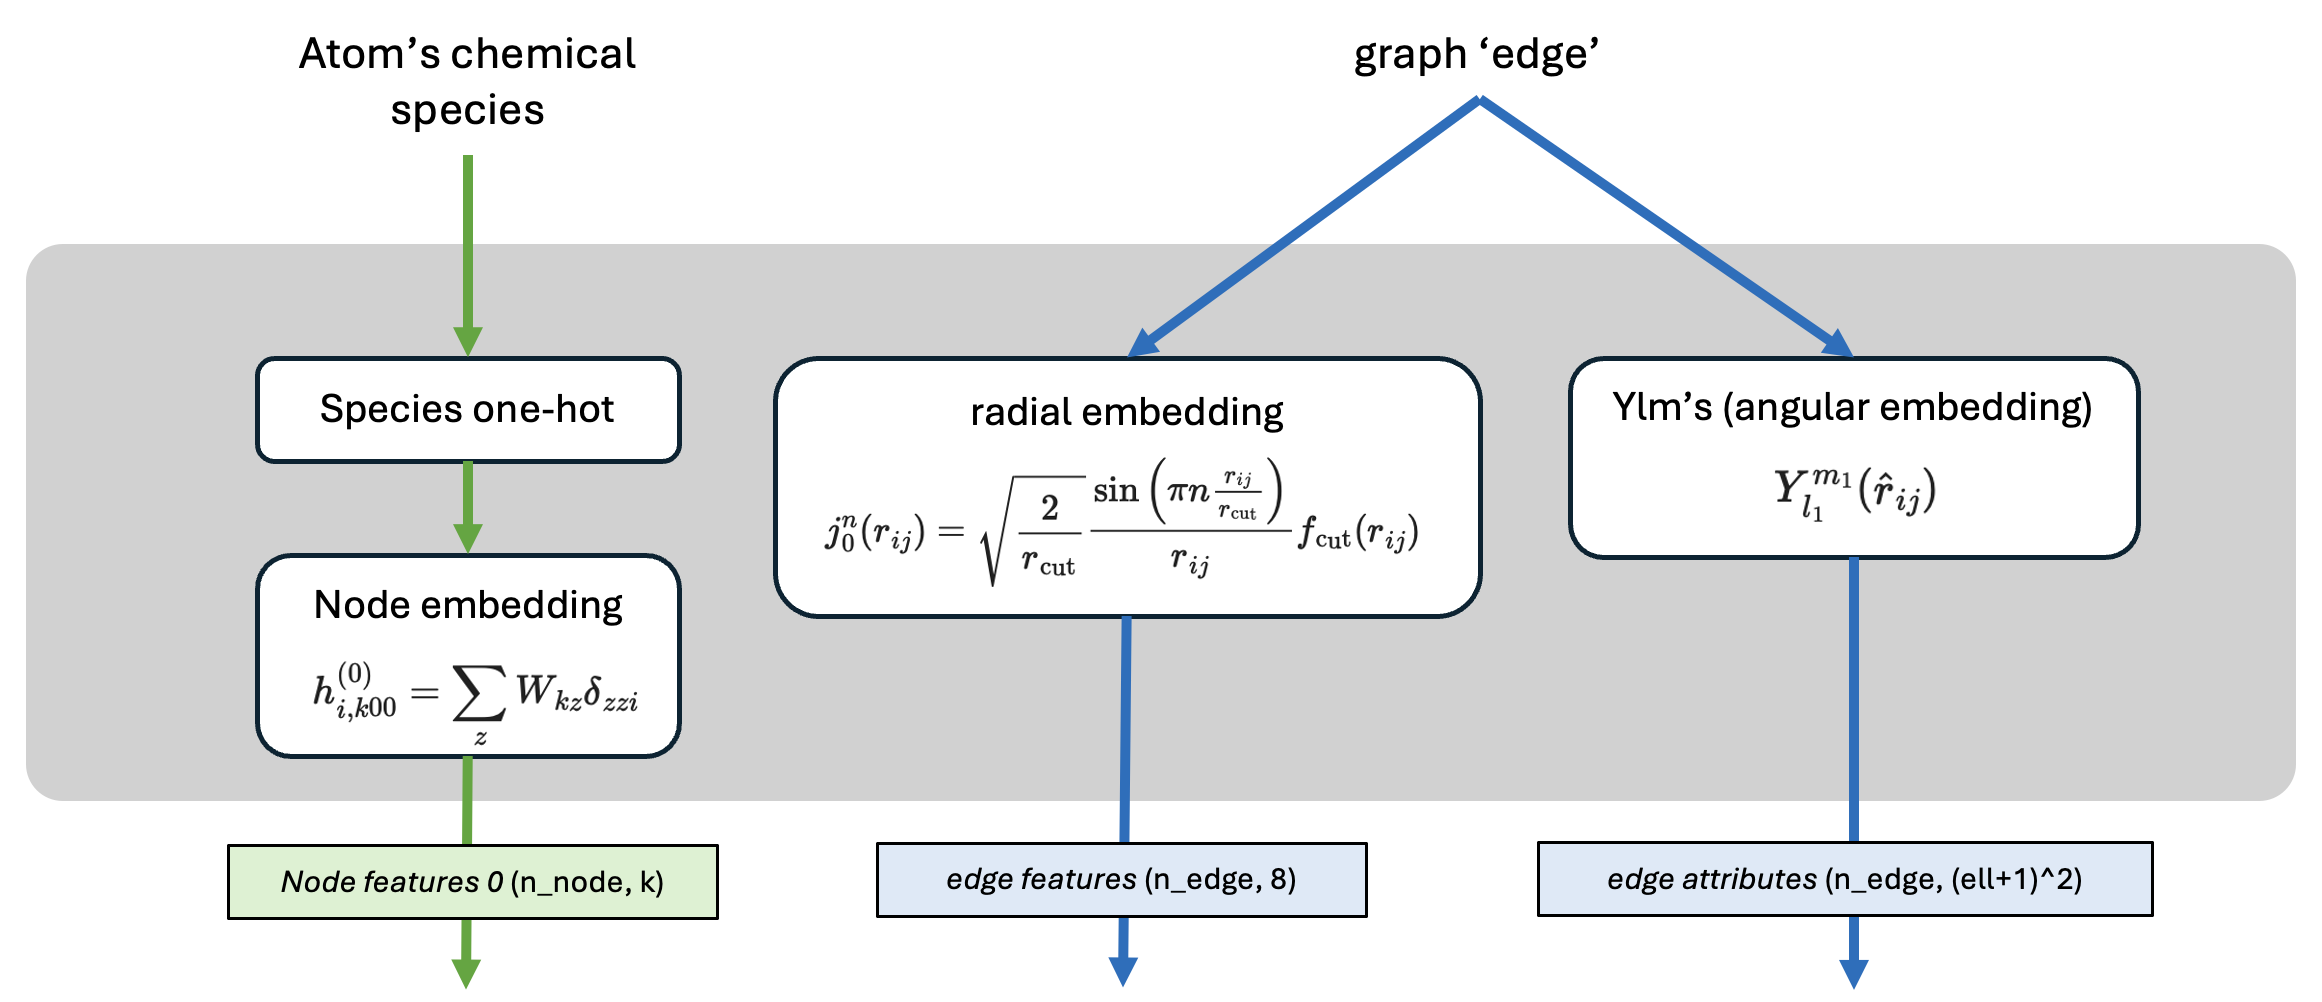

In [18]:
default_model_config

{'num_elements': 3,
 'atomic_energies': array([-1., -3., -5.]),
 'avg_num_neighbors': 8,
 'atomic_numbers': [1, 6, 8],
 'r_max': 3,
 'num_bessel': 8,
 'num_polynomial_cutoff': 6,
 'max_ell': 2,
 'num_interactions': 2,
 'interaction_cls_first': hforge.mace.modules.blocks.RealAgnosticResidualInteractionBlock,
 'interaction_cls': hforge.mace.modules.blocks.RealAgnosticResidualInteractionBlock,
 'hidden_irreps': 8x0e+8x1o,
 'correlation': 3,
 'MLP_irreps': 16x0e,
 'gate': <function torch.nn.functional.silu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>}

In [34]:
# set up a mace model to get all of the blocks in one place:
model = modules.MACE(**default_model_config)

initial_node_features = model.node_embedding(batch.node_attrs)
edge_features = model.radial_embedding(lengths, batch["node_attrs"], batch["edge_index"], z_table)
edge_attributes = model.spherical_harmonics(vectors)

print('initial_node_features is (num_atoms, num_channels):', initial_node_features.shape)
print('edge_features is (num_edge, num_bessel_func):', edge_features.shape)
print('edge_attributes is (num_edge, dimension of spherical harmonics):', edge_attributes.shape)
print(
    '\nInitial node features. Note that they are the same for each chemical element\n',
    initial_node_features
)

node fut -1: type(self.node_feats_irreps)=<class 'e3nn.o3._irreps.Irreps'>
IRREPS 8x0e 1x0e+1x1o+1x2e
IRREPS type <class 'e3nn.o3._irreps.Irreps'> <class 'e3nn.o3._irreps.Irreps'>
node fut -1: type(self.node_feats_irreps)=<class 'e3nn.o3._irreps.Irreps'>
IRREPS 8x0e+8x1o 1x0e+1x1o+1x2e
IRREPS type <class 'e3nn.o3._irreps.Irreps'> <class 'e3nn.o3._irreps.Irreps'>
initial_node_features is (num_atoms, num_channels): torch.Size([5, 8])
edge_features is (num_edge, num_bessel_func): torch.Size([18, 8])
edge_attributes is (num_edge, dimension of spherical harmonics): torch.Size([18, 9])

Initial node features. Note that they are the same for each chemical element
 tensor([[ 0.7508, -0.7231, -0.4179, -0.6645, -0.4549,  0.1631,  0.6955,  0.3173],
        [ 1.1418, -0.4699,  0.1395,  0.2251, -0.4273, -0.2106,  0.5825,  0.3678],
        [ 1.1418, -0.4699,  0.1395,  0.2251, -0.4273, -0.2106,  0.5825,  0.3678],
        [-0.1890, -1.1802,  1.0414, -0.2769,  0.4498,  0.0214, -0.3886,  0.2455],
      

In [35]:
batch["node_attrs"].shape

torch.Size([5, 3])

In [36]:
batch["node_attrs"]

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])

In [37]:
batch["edge_index"].shape

torch.Size([2, 18])

In [38]:
lengths.shape

torch.Size([18, 1])

In [39]:
 z_table.index_to_z(2)

8

In [40]:
initial_node_features.shape

torch.Size([5, 8])

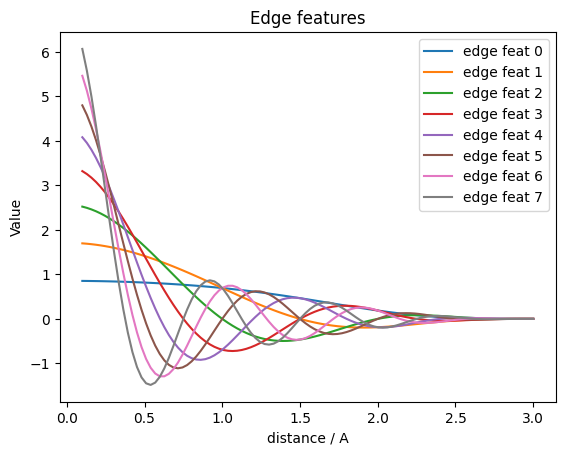

In [41]:
# we can plots what the 'edge features' look like as a function of edge length:
dists = torch.tensor(np.linspace(0.1, cutoff, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)
radials = model.radial_embedding(dists, batch["node_attrs"], batch["edge_index"], z_table)

for i in range(radials.shape[1]):
    plt.plot(dists, radials[:, i], label=f'edge feat {i}')

# Add title, labels, and legend
plt.title("Edge features")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plots
plt.show()

The parameter `max_ell` in the mace config (top of file) controls the maximum $l$ in the spherical harmonics, and hence the dimension of the `edge_attributes`.

The intial node features are invariant, and depend only on the speices. You can check this by printing them and comparing to `batch.node_attrs`.

The edge features are invariant because they only depend on length, and the edge attributes are of course spherical harmonics, and change as things rotate.

In [42]:
batch.node_attrs

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])


## 2. Interaction

Having created the intial features, the fun begins. The interaction block is tasked with pooling information over neighbours while tracking the properties of all arrays with $(l,m)$ indices. The output is a set of atomic features which contain information about the neighbours but are still 2-body.

The figure below shows all the equations of the interaction which is used in the first layer. In the second layer of mace, the interaction step is significantly more complex - the end of this notebook discusses this if you are interested.

The first layer of MACE is actually very similar to the simpler, and related, ACE model. We won't go through the internals of the interaction, but its at the end of the notebook if you are interested.

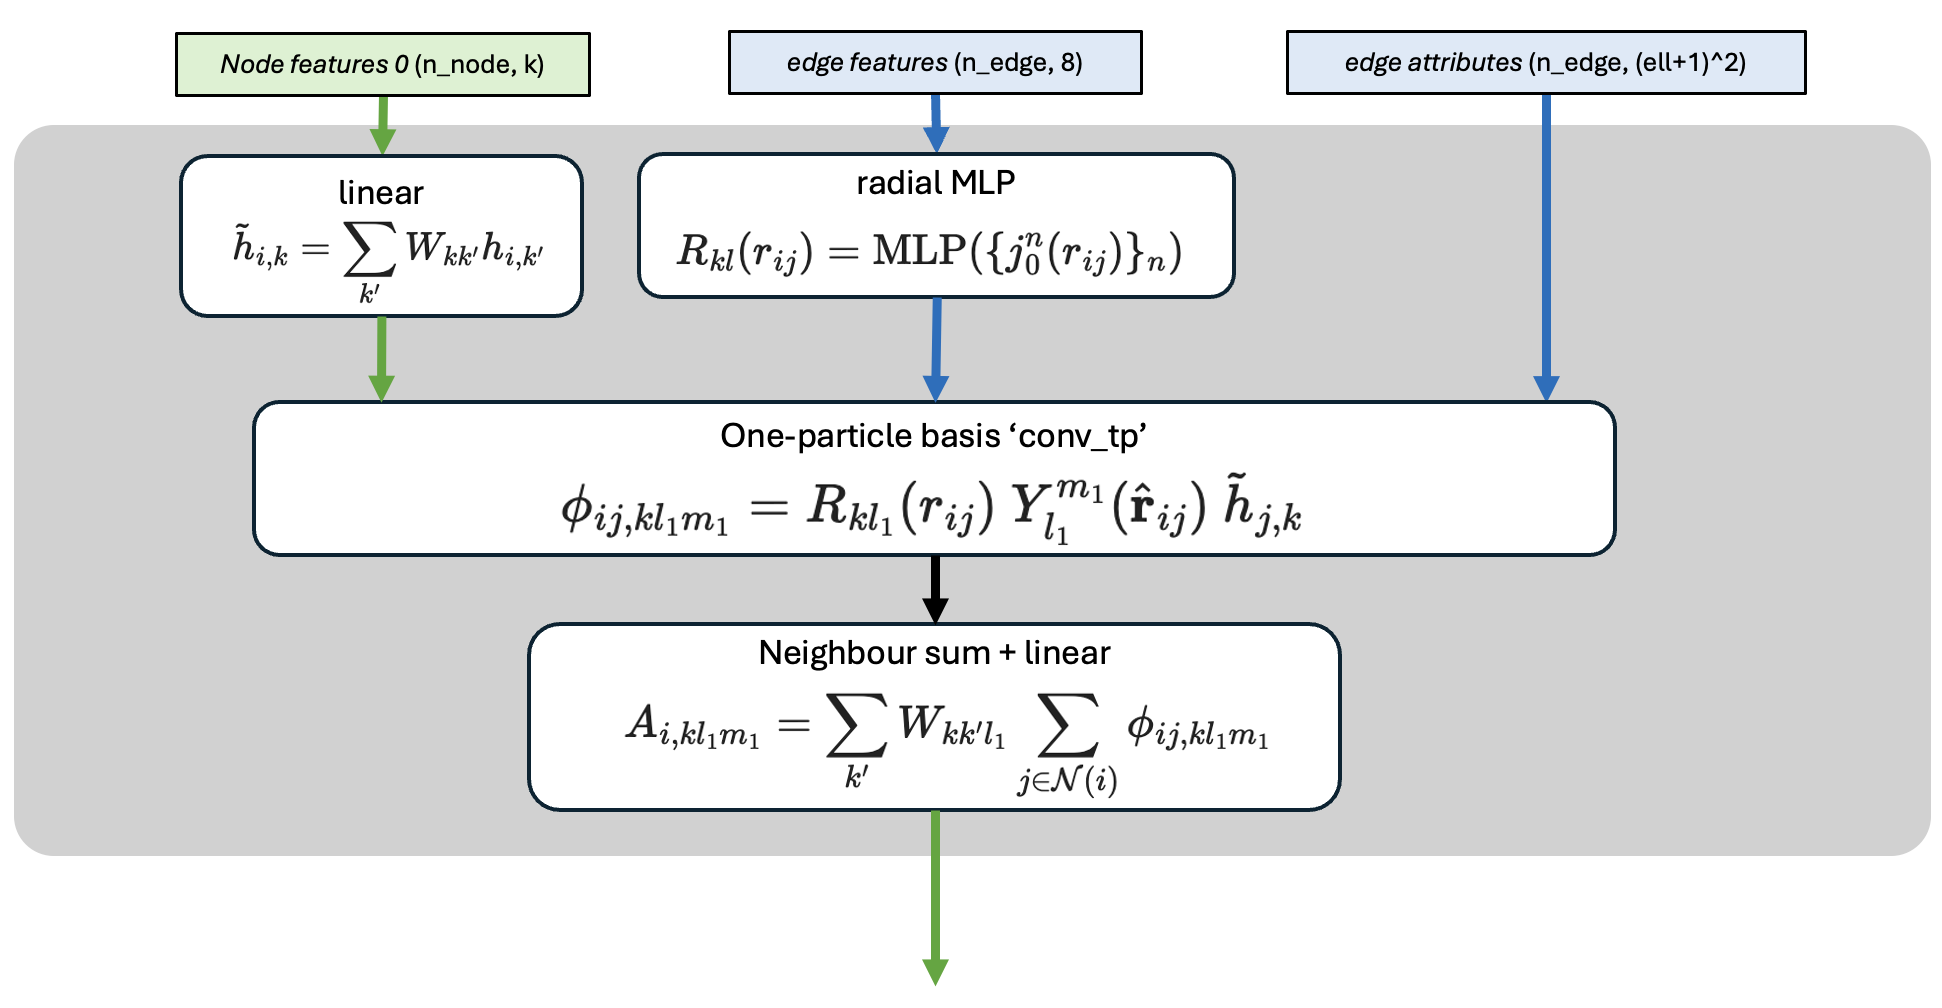

In [43]:
Interaction = model.interactions[0]

intermediate_node_features, sc = Interaction(
    node_feats=initial_node_features,
    node_attrs=batch.node_attrs,
    edge_feats=edge_features,
    edge_attrs=edge_attributes,
    edge_index=batch.edge_index,
)

print("the output of the interaction is (num_atoms, channels, dim. spherical harmonics):", intermediate_node_features.shape)

node feature and atribute shapes  torch.Size([5, 8]) torch.Size([5, 3])
the output of the interaction is (num_atoms, channels, dim. spherical harmonics): torch.Size([5, 8, 9])


In [44]:
initial_node_features.shape

torch.Size([5, 8])

In [45]:
batch.node_attrs.shape

torch.Size([5, 3])

In [46]:
edge_features.shape

torch.Size([18, 8])

In [47]:
edge_attributes.shape

torch.Size([18, 9])

In [48]:
Interaction

RealAgnosticResidualInteractionBlock(
  (linear_up): Linear(8x0e -> 8x0e | 64 weights)
  (conv_tp): TensorProduct(8x0e x 1x0e+1x1o+1x2e -> 8x0e+8x1o+8x2e | 24 paths | 24 weights)
  (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 24]
  (linear): Linear(8x0e+8x1o+8x2e -> 8x0e+8x1o+8x2e | 192 weights)
  (skip_tp): FullyConnectedTensorProduct(8x0e x 3x0e -> 8x0e+8x1o | 192 paths | 192 weights)
  (reshape): reshape_irreps()
)

In [49]:
Interaction.node_attrs_irreps

3x0e

In [50]:
Interaction.node_feats_irreps

8x0e

In [51]:
Interaction.edge_attrs_irreps

1x0e+1x1o+1x2e

In [52]:
Interaction.edge_feats_irreps

8x0e

In [53]:
Interaction.target_irreps

8x0e+8x1o+8x2e

In [54]:
Interaction.hidden_irreps

8x0e+8x1o

In [55]:
default_model_config

{'num_elements': 3,
 'atomic_energies': array([-1., -3., -5.]),
 'avg_num_neighbors': 8,
 'atomic_numbers': [1, 6, 8],
 'r_max': 3,
 'num_bessel': 8,
 'num_polynomial_cutoff': 6,
 'max_ell': 2,
 'num_interactions': 2,
 'interaction_cls_first': hforge.mace.modules.blocks.RealAgnosticResidualInteractionBlock,
 'interaction_cls': hforge.mace.modules.blocks.RealAgnosticResidualInteractionBlock,
 'hidden_irreps': 8x0e+8x1o,
 'correlation': 3,
 'MLP_irreps': 16x0e,
 'gate': <function torch.nn.functional.silu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>}

One important part of the interaction is how the `edge_attrs` (the bessel function values) enter.

The bessel function values are mapped through a multilayer perceptron ('radial MLP') to make a large number of learnable functions of edge length. The output is sometimes called a 'learnable raidal basis' $R_{kl}(r_{ij})$ - one radial function for each $(k,l)$ combination.

These learnable functions are then combined with the spherical harmonics of the $j\rightarrow i$ edge, and the initial node features of the neighbouring atom ($j$). The result is that $\phi_{ij,klm}(\mathbf{r}_{ij})$ is quite a rich set of descriptors of the $j$'th neighbour atom.

We can plot some of these radial functions to see how kind of shapes they have.

the output of the radial MLP is (num_dists, num_weights): (100, 24)


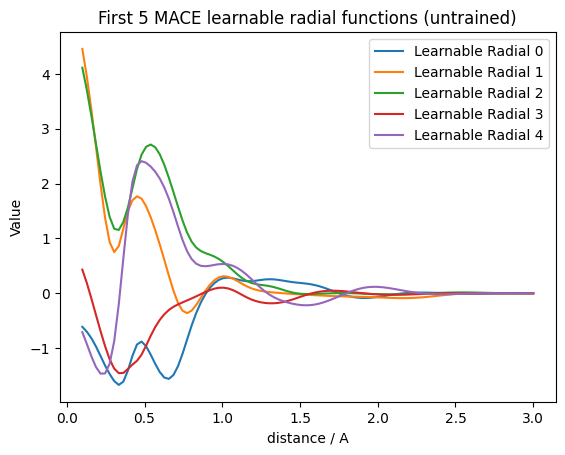

In [56]:
# visulaise what the radial MLP does
dists = torch.tensor(np.linspace(0.1, cutoff, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)

# first do radial embedding again
edge_feats_scan = model.radial_embedding(dists, batch["node_attrs"], batch["edge_index"], model.atomic_numbers)

# put the edge feats into the radial MLP
tp_weights_scan = model.interactions[0].conv_tp_weights(edge_feats_scan).detach().numpy()
print('the output of the radial MLP is (num_dists, num_weights):', tp_weights_scan.shape)

# plots the outputs
num_basis_to_print = 5
for i in range(num_basis_to_print):
    plt.plot(dists, tp_weights_scan[:, i], label=f'Learnable Radial {i}')

# Add title, labels, and legend
plt.title(f"First {num_basis_to_print} MACE learnable radial functions (untrained)")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plots
plt.show()

Of course these functional forms will change after training.


## 3. Product

The key operation of MACE is the efficient construction of higher order features from the ${A}_{i}^{(t)}$-features (the output of the interaction).
This is achieved by first forming tensor products of the features, and then symmetrising, as shown in the figure. This operation:
$$
{B}^{(t)}_{i,\eta_{\nu} k LM}
= \sum_{{l}{m}} \mathcal{C}^{LM}_{\eta_{\nu}, l m} \prod_{\xi = 1}^{\nu} A_{i,k l_\xi  m_\xi}^{(t)}
$$
is essentially doing $A_{lm} \otimes A_{lm} \otimes ...$ and eventually getting back to something which transforms in a known way - ${B}^{(t)}_{i,\eta_{\nu} k LM}$. It happens on each node - all pooling between neighbours is done in the interction.

Like in the example above with two vectors, this product operation creates features which have angular information, but which are still invariant.

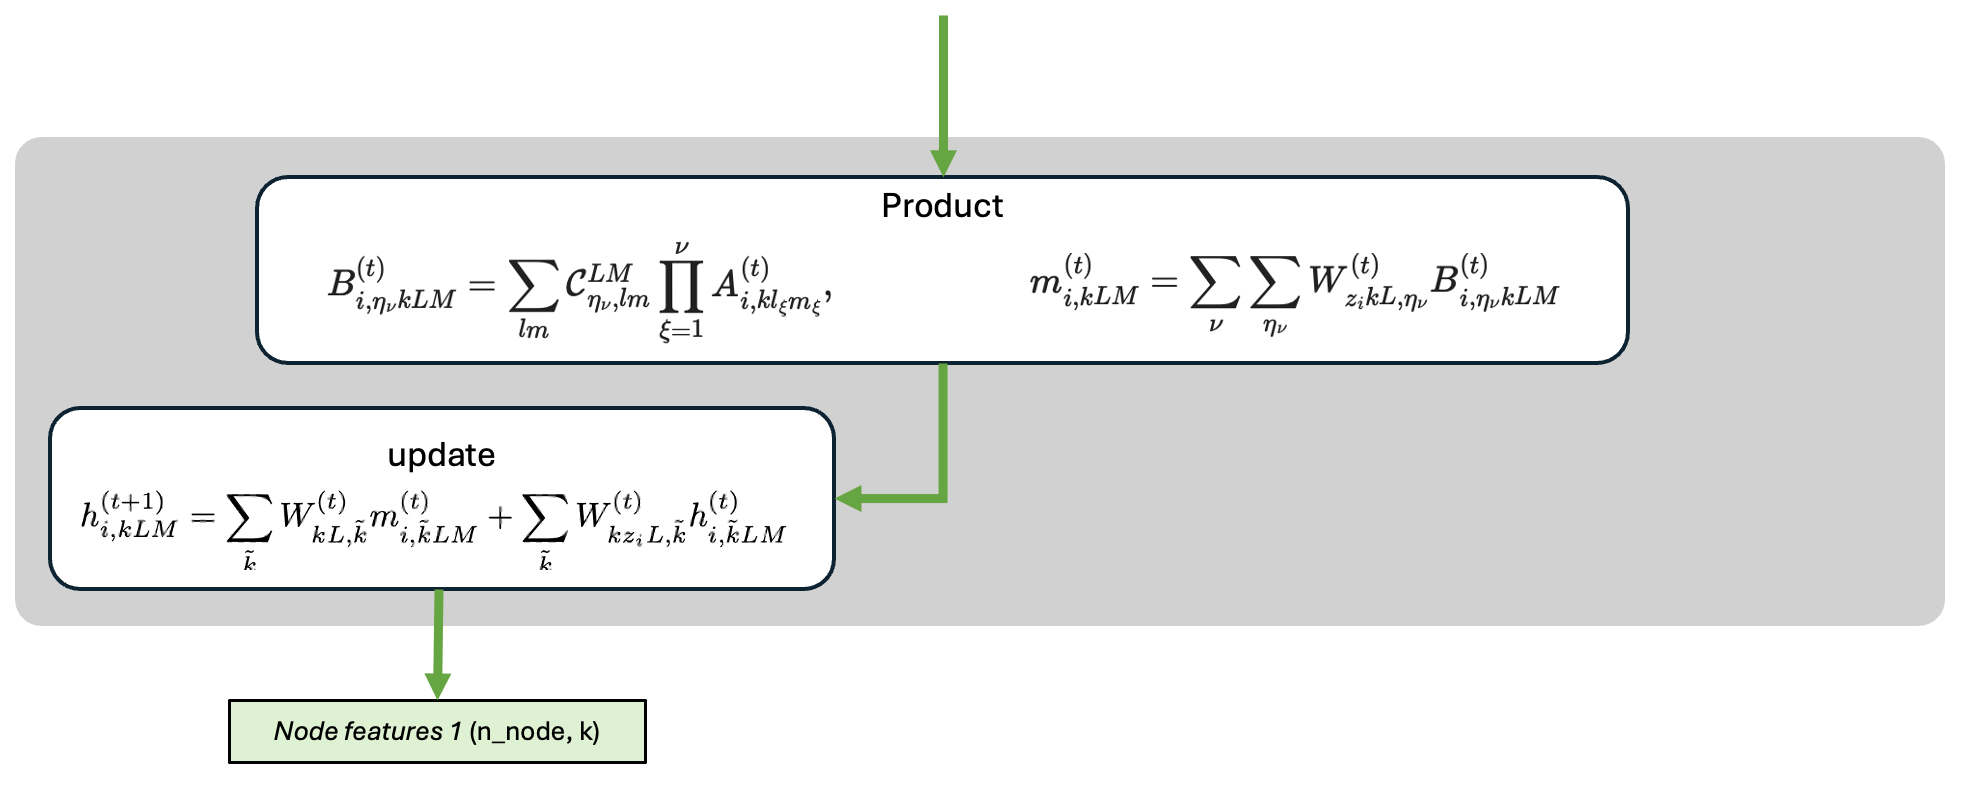

The final part of the product is to linearly mix everything together and create a new set of node features.

These node features don't have to be invariant. Its possible to retain some level of equivariance and then use this extra information in the second layer of MACE, where the whole interaction an product is repeated.

Whether to do this is controlled by the `max_L` parameter to MACE (see the model config). If this is set to 0, then only invariant features are retained. If it is set to 1 (which is the case here), the new node features will have $l=0$ and $l=1$ pieces.

In [57]:
new_node_features = model.products[0](
    node_feats=intermediate_node_features,
    node_attrs=batch.node_attrs,
    sc=sc,
)
print('new node feats are (num_atoms, (L+1)^2 * num_channels):', new_node_features.shape)

new node feats are (num_atoms, (L+1)^2 * num_channels): torch.Size([5, 32])


you should find that the array is (num_atoms, 32), since 32=8*4, where 4 is because we have $[Y_{00}, Y_{1,-1}, Y_{1,0}, Y_{1,1}]$ pieces, and 8 is because we have 8 'channels'.

You can check the equivariance of these features by modifying the above code to read a different config from `rotated_solvent.xyz`. This will be the same structure, but rotated. You should see that the first 32 elements are the same (since they are invariant) and the rest change.


## 4. Readout

Finally, we can take the new node features and create an actual energy. This is done by passing the node features through a `readout`.

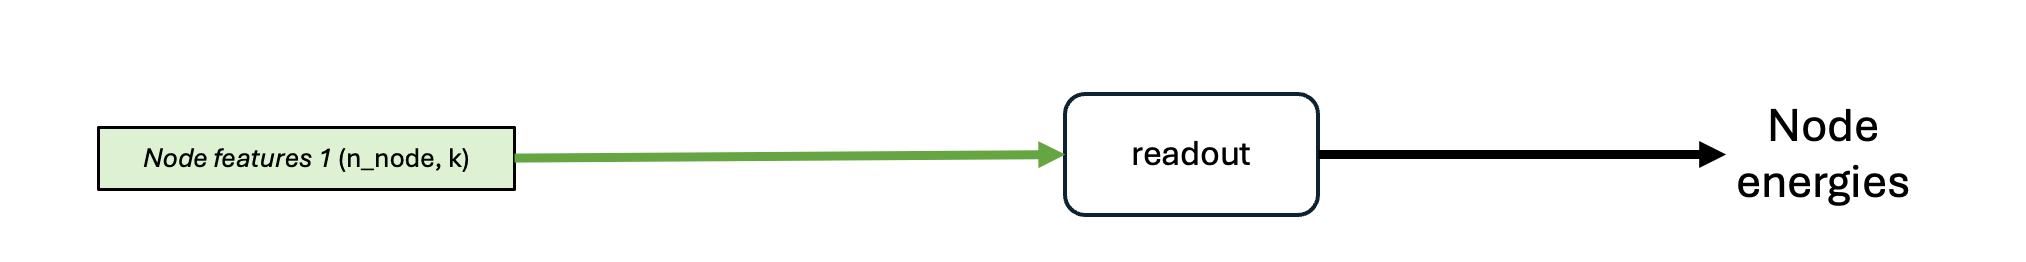

In an $S$-layer MACE, the readout from the features at layer $s$ is:

\begin{equation*}
    \mathcal{R}^{(s)} \left( \boldsymbol{h}_i^{(s)} \right) =
    \begin{cases}
      \sum_{k}W^{(s)}_{k}h^{(s)}_{i,k00}     & \text{if} \;\; 1 < s < S \\[13pt]
      {\rm MLP} \left( \left\{ h^{(s)}_{i,k00} \right\}_k \right)  &\text{if} \;\; s = S
    \end{cases}
\end{equation*}

In our example case this maps the 32 dimensional $h^{(1)}_{i,k00}$, the invariant part os the node features after the first interaction to the first term in the aotmic site energy:

In [58]:
print('first readout =', model.readouts[0], '\n')

energy_layer_1 = model.readouts[0](new_node_features)
print('energy_layer_1:', energy_layer_1.shape)
print(energy_layer_1)

first readout = LinearReadoutBlock(
  (linear): Linear(8x0e+8x1o -> 1x0e | 8 weights)
) 

energy_layer_1: torch.Size([5, 1])
tensor([[-0.1418],
        [ 0.0284],
        [ 0.0250],
        [-0.3075],
        [ 0.0047]], grad_fn=<ViewBackward0>)


And we have made an energy for each node!

## 5. Repeat

The Interaction, product and readout are repeated twice, and all the atomic energy contributions are summed up to get the total energy.

# Interaction Block in more detail

At the second layer, the interaction block has a much harder task. This is because the features at the end of the first MACE layer may not be scalar, but may have an $(l,m)$ index pair.

In general, the equations for layer $s$ are:

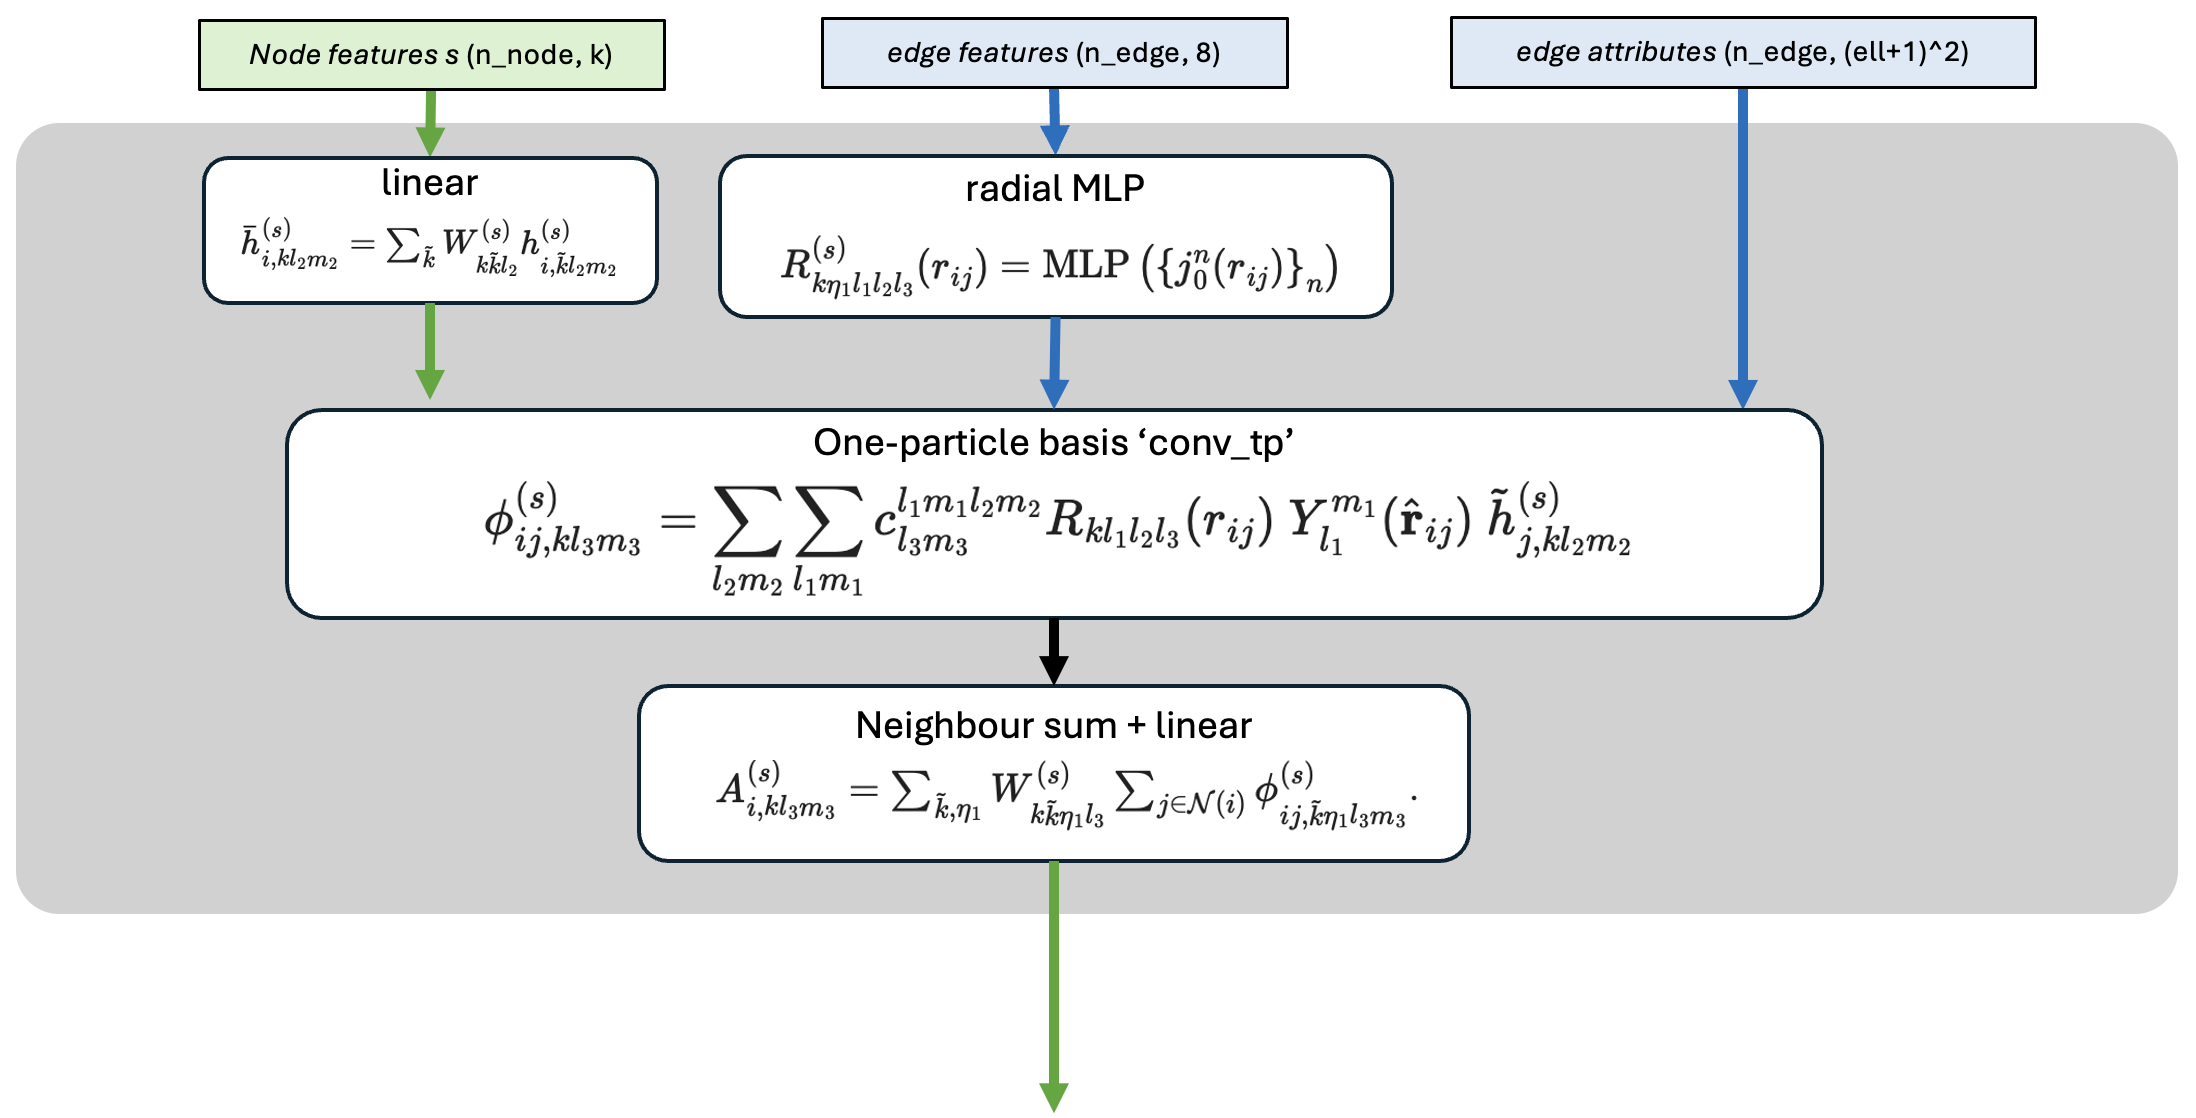

In this case, the learnable radial functions have a more complicated funciton.

These learnable functions are then used as weights in the operation that follows, which does a product between the $j\rightarrow i$ edge and the initial features of node $j$. You can see the detail in the equations above if you are interested.

Because the learnable functions are used as weights in the following `conv_tp` operation, the output shape is just the number of weights required by that block, and they are all invariants.

### Task

If you really want to understand whats going on, try to work out what the output shape of the radial MLP in the second layer should be. You can access the block using some of the code snippets below:

the output of the radial MLP is (num_dists, num_weights): (100, 56)


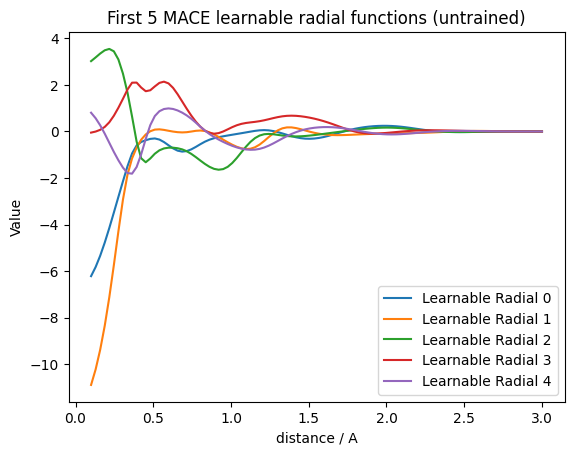

In [59]:
# visulaise what the radial MLP does
dists = torch.tensor(np.linspace(0.1, cutoff, 100), dtype=torch.get_default_dtype()).unsqueeze(-1)

# first do radial embedding again
edge_feats_scan = model.radial_embedding(dists, batch["node_attrs"], batch["edge_index"], model.atomic_numbers)

# put the edge feats into the radial MLP
### model.interactions[1] for the second layer!!!!
# conv_tp_weights is the name for the radial MLP...
tp_weights_scan = model.interactions[1].conv_tp_weights(edge_feats_scan).detach().numpy()
print('the output of the radial MLP is (num_dists, num_weights):', tp_weights_scan.shape)


# plots the outputs if you want
num_basis_to_print = 5
for i in range(num_basis_to_print):
    plt.plot(dists, tp_weights_scan[:, i], label=f'Learnable Radial {i}')

# Add title, labels, and legend
plt.title(f"First {num_basis_to_print} MACE learnable radial functions (untrained)")
plt.xlabel("distance / A")
plt.ylabel("Value")
plt.legend()

# Display the plots
plt.show()